In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import glob
# sys.path.insert(0, 'C:\\Users\\EPL User\\Documents\\GitHub\wcmelby-HWP_Characterizations\\operational_scripts')
sys.path.insert(0, '../../operational_scripts')

from New_DRRP_Functions import dark_subtract, find_pixels, extract_intensities, q_ultimate_polarimetry, I_ultimate_polarimetry
# from New_DRRP_Functions import *

In [1]:
# through stokes and exoserver
img_file = '/home/shared/exoserver/Lab_Data/Mueller_Matrix_Polarimeter/L_Plate_Characterization/SuperK_Select_Data/Calibrations/Calibration_Reduced/SK_Cal_1100_Reduced/Reduced_DRRP_Cal_1100nm_490_2_151.9999072265625.fits'

In [ ]:
# TODO: check for oversaturated pixels and remove them
# TODO: automate data reduction process
# TODO: remove cutoff function?
# TODO: make sure image taking functions (specifically darks) aren't taking the same images multiple times in a cube
# TODO: make a function to automatically find the center of the beam and the radius. Use this to crop the image around the beam and only use those pixels
# TODO: test if closing hdul makes dark subtraction faster
# TODO: make reduce function that not only subtracts darks but also crops the image around the circles
# TODO: update dark_subtract function to accept multiple dark files, allowing for multiple wavelength subtraction with different camera settings
# TODO: make some python classes within new DRRP functions (analysis, data, etc)
# TODO: maybe break up new drrp functions to organize better in terms of functions

In [8]:
# waveplate data that needs to be dark subtracted: (even though the folders start with Cal). C for completed calibration subtractions
# 1100 nm, 10 fps, 99 tint          done   c
# 1200 nm, 10 fps, 18 tint       done  c
# 1300, 10 fps, 2 tint            done  c
# 1400, 10 fps, 1 tint            done  c
# 1500, 10, 1                   done  c
# 1600, 10, 1                     done  c
# 1750, 10, 1                      done  c
# 1850, 10, 2                   done  c
# 1950, 10, 3                   done  c

wavelengths = [] # enter wavelengths like [1100, 1850] in nm
dark_file_path =  r"D:\desktop_drrp_data\test_12_17_2024\darks\-40.0C_tint_3_FPS_10.fits"
foldername_base = r"D:\desktop_drrp_data\test_12_17_2024\JHK_waveplate_measurement\x_5_y_5"

1950 definitely has some oversaturated pixels in x_5 y_5

In [9]:
dark_subtract([1950], dark_file_path, foldername_base)

Reducing images...
Images have been reduced for wavelength 1950. Process finished.


In [49]:
img_file = r"D:\desktop_drrp_data\test_12_17_2024\darks\-40C_tint_1_FPS_10.fits"
find_pixels(img_file)

No pixels found in D:\desktop_drrp_data\test_12_17_2024\darks\-40C_tint_1_FPS_10.fits with value 16383.


In [75]:
# old version

def find_circles(img_directory):
    """
    Find the center and radius of a circular bright spot.
    """
    img_files = glob.glob(os.path.join(img_directory, '*'))
    img_file = img_files[2]  # take the third image, which should be a good example
    print(img_file)

    with fits.open(img_file) as hdul:
        img_data = hdul[0].data
        # try to do median if it's a cube
        # img_data = np.median(img_data, axis=0)
        hdul.close()

    # Step 1: Check the shape of the image data
    print(f"Image data shape: {img_data.shape}")
    
    # Step 2: Preprocess the image (apply thresholding or smoothing)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(img_data.astype(np.uint8))
    blurred_image = cv2.GaussianBlur(enhanced_image, (15, 15), 0)
    
    # Step 4: Threshold the image (adjust thresholding for faint circles)
    _, thresholded_image = cv2.threshold(blurred_image, np.max(blurred_image) * 0.3, 255, cv2.THRESH_BINARY)

    # Step 5: Apply Hough Circle Transform with adjusted parameters
    circles = cv2.HoughCircles(thresholded_image.astype(np.uint8),
                               cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                               param1=100, param2=20, minRadius=10, maxRadius=100)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = sorted(circles, key=lambda x: x[2], reverse=True)[:2]
        
        for circle in circles:
            center = (circle[0], circle[1])
            radius = circle[2]
            print(f"Circle center: {center}, radius: {radius}")
            
            # Optionally, draw the circle
            output_image = img_data.copy()
            cv2.circle(output_image, center, radius, (0, 255, 0), 4)  # Draw the circle
            cv2.rectangle(output_image, (center[0] - 5, center[1] - 5),
                          (center[0] + 5, center[1] + 5), (0, 128, 255), -1)  # Draw the center
            
            # Display the result with origin at the lower left
            plt.imshow(output_image, cmap='gray', origin='lower')
            plt.show()
    else:
        print("No circles detected.")


In [87]:
# version that plots in yellow

def find_circles(img_directory):
    """
    Find the center and radius of a circular bright spot and overlay the detected circle and center in yellow.
    """
    img_files = glob.glob(os.path.join(img_directory, '*'))
    img_file = img_files[2]  # take the third image
    print("Using image:", img_file)

    with fits.open(img_file) as hdul:
        img_data = hdul[0].data
        hdul.close()

    print(f"Image data shape: {img_data.shape}")

    # Directly cast to uint8 if the image is already in a roughly 0-255 range.
    if img_data.dtype != np.uint8:
        img_data = img_data.astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(img_data)
    blurred_image = cv2.GaussianBlur(enhanced_image, (15, 15), 0)

    # You might adjust the threshold multiplier if needed.
    _, thresholded_image = cv2.threshold(blurred_image, np.max(blurred_image) * 0.3, 255, cv2.THRESH_BINARY)

    circles = cv2.HoughCircles(thresholded_image,
                               cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                               param1=100, param2=20, minRadius=10, maxRadius=100)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = sorted(circles, key=lambda x: x[2], reverse=True)[:2]
        output_image = cv2.cvtColor(img_data, cv2.COLOR_GRAY2BGR)
        
        for circle in circles:
            center = (circle[0], circle[1])
            radius = circle[2]
            print(f"Circle center: {center}, radius: {radius}")
            cv2.circle(output_image, center, radius, (0, 255, 255), 4)
            cv2.rectangle(output_image, (center[0] - 5, center[1] - 5),
                          (center[0] + 5, center[1] + 5), (0, 255, 255), -1)
        
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), origin='lower')
        plt.title("Detected Circles")
        plt.show()
    else:
        print("No circles detected.")

In [81]:
def find_two_largest_circles(img_directory):
    """
    Detect circles in the image using HoughCircles, select the two largest circles,
    and print their centers and radii.
    """
    # Get list of image files and choose the third image.
    img_files = glob.glob(os.path.join(img_directory, '*'))
    if len(img_files) < 3:
        print("Not enough images found in the directory.")
        return

    img_file = img_files[2]
    print("Using image:", img_file)

    # Open the FITS file.
    with fits.open(img_file) as hdul:
        img_data = hdul[0].data
        hdul.close()

    print("Original image shape:", img_data.shape)

    # Convert the image to 8-bit.
    # Option 1: Direct casting if the image is already near 0-255.
    # Uncomment the following line if you believe the original data is in that range:
    img_uint8 = img_data.astype(np.uint8)
    
    # Option 2: Normalize to the full 0-255 range, then convert.
    img_norm = cv2.normalize(img_data, None, 0, 255, cv2.NORM_MINMAX)
    img_uint8 = img_norm.astype(np.uint8)

    # Apply CLAHE to enhance contrast.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(img_uint8)

    # Apply Gaussian blur.
    blurred_image = cv2.GaussianBlur(enhanced_image, (15, 15), 0)

    # Threshold the image.
    # You may need to adjust the multiplier (0.3) depending on your image.
    thresh_value = np.max(blurred_image) * 0.3
    ret, thresholded_image = cv2.threshold(blurred_image, thresh_value, 255, cv2.THRESH_BINARY)
    print("Threshold value used:", thresh_value)
    
    # Uncomment the following lines to inspect the thresholded image:
    import matplotlib.pyplot as plt
    plt.imshow(thresholded_image, cmap='gray')
    plt.title("Thresholded Image")
    plt.show()
    
    # Use Hough Circle Transform to detect circles.
    circles = cv2.HoughCircles(
        thresholded_image,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=100,
        param2=20,
        minRadius=10,
        maxRadius=100
    )

    if circles is not None:
        # Convert the (x, y, r) values to integers.
        circles = np.round(circles[0, :]).astype("int")
        print("Total circles detected:", len(circles))
        
        # Sort circles by radius in descending order and select the two largest.
        circles_sorted = sorted(circles, key=lambda x: x[2], reverse=True)[:2]
        
        for i, circle in enumerate(circles_sorted, start=1):
            x, y, r = circle
            print(f"Circle {i}: Center = ({x}, {y}), Radius = {r}")
    else:
        print("No circles detected.")

Using image: D:\desktop_drrp_data\test_12_17_2024\calibration\calibration_raw\Cal_1600_Reduced\Reduced_DRRP_JHK_1600nm_FPS_10_tint_1_QWP1_position_104_QWP2_position_520.fits
Image data shape: (512, 640)
Circle center: (223, 211), radius: 98
Circle center: (355, 241), radius: 95


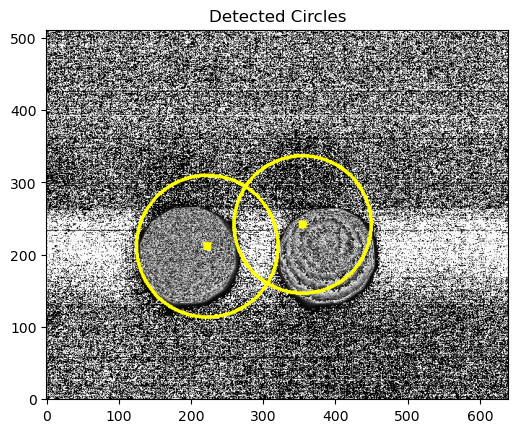

In [88]:
# try to work with the third image in the folder
img_directory = r"D:\desktop_drrp_data\test_12_17_2024\calibration\calibration_raw\Cal_1600_Reduced"
find_circles(img_directory)

# Looking at calibration data manually 

In [2]:
reduced_filename = ''
reduced_folder = "D:\\desktop_drrp_data\\test_12_17_2024\\calibration\\calibration_raw\\Cal_1100_Reduced"
lcenter = [200, 194]
rcenter = [200, 391]
maxradius = 65
# cutoff = 100000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
Cal_Il_1100 = extracted_data[0]
Cal_Ir_1100 = extracted_data[1]
Cal_theta1100 = extracted_data[2]

In [3]:
print(Cal_Il_1100)
print(len(Cal_Il_1100))
print(Cal_Ir_1100)
# print(Cal_theta1100)

[ 5107672.  3469014. 23457266. 38545607. 30120746. 10352465.   572618.
  4750602. 12469129. 19936648. 31980844. 47039335. 53077076. 44572352.
 29615132. 17911785.  8494573.  1146519.  4016949. 21801323. 39568767.
 36483136. 14668381.   750306. 11684113. 32125844. 35964674. 19619846.
  3322196.  1474779.  8592542. 15741303. 24700901. 39068818. 51091998.
 49614851. 36788959. 23151166. 12985554.  4178451.   684476. 11565894.
 32372778. 41647434. 26670391.  5027262.]
46
[49760953.  51445147.  31445594.  16531609.  24483177.  44227202.
 54058008.  49740278.  41705355.  34194749.  22025441.   7103445.
  1132038.   9387125.  23839620.  35668418.  44963020.  52420759.
 49405599.  31522866.  13815409.  16848831.  38398350.  52503589.
 41376014.  20771252.  17090895.  33126271.  49595431.  51588200.
 44160681.  36982269.  28109860.  13973675.   2307315.   3613940.5
 16321380.  29953516.5 40189949.  49210185.  53100841.  42022051.
 21292870.  12238247.  26851687.  48589926. ]


# Looking at sample data manually

data_folder = "D:\desktop_drrp_data\test_12_17_2024\JHK_waveplate_measurement\middle_position\Cal_1400_Raw"

In [4]:
reduced_filename = ''
reduced_folder = "D:\\desktop_drrp_data\\test_12_17_2024\\JHK_waveplate_measurement\\middle_position\\Cal_1100_Reduced"
lcenter = [200, 194]
rcenter = [200, 391]
maxradius = 65
# cutoff = 1000000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
Il_1100 = extracted_data[0]
Ir_1100 = extracted_data[1]
theta1100 = extracted_data[2]

In [5]:
data1100 = q_ultimate_polarimetry(Cal_theta1100, Cal_Il_1100, Cal_Ir_1100, theta1100, Il_1100, Ir_1100)
print(data1100[0], "This is the Mueller matrix of the sample waveplate")
print(data1100[1], "This is the retardance of the sample")
print(data1100[2], "This is the Mueller matrix for calibration (close to identity)")
print(data1100[3], "This is the RMS error in the calibration matrix")
print(data1100[4], "This is the retardance error in the sample waveplate")
print(data1100[5], "Fit parameters for a1, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")

[[ 1.         -0.00517202 -0.02681904 -0.00502388]
 [-0.07844337  0.82470972 -0.6504669  -0.03236352]
 [ 0.0521396  -0.69468433 -0.91097301 -0.1993286 ]
 [-0.00586219  0.06499284  0.17813878 -0.96205716]] This is the Mueller matrix of the sample waveplate
nan This is the retardance of the sample
[[ 0.86933388  0.00568932  0.00340845  0.00792505]
 [-0.06924408  0.90379655  0.00685527  0.00323584]
 [ 0.00162457  0.02416009  1.          0.00169272]
 [ 0.00653545 -0.00441184  0.01094866  0.85429863]] This is the Mueller matrix for calibration (close to identity)
0.05771042681587322 This is the RMS error in the calibration matrix
nan This is the retardance error in the sample waveplate
[-0.02982799 -0.09012526 -0.19713471  0.0474203   0.03576804] Fit parameters for a1, w1, w2, r1, and r2. 1 for generator, 2 for analyzer


c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:836: RuntimeWarning: invalid value encountered in arccos
  retardance = np.arccos(np.trace(r_decomposed_MSample)/2 - 1)/(2*np.pi) # Value in waves
c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:320: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


# Testing data with many wavelengths

In [2]:
# List of wavelengths to process
wavelengths = [1100, 1200, 1300, 1400, 1500, 1600, 1750, 1850, 1950]

# Constants that don't change across wavelengths
reduced_filename = '' # can include the start of the filename, like 'Reduced_', or not
lcenter = [198, 194]
rcenter = [198, 391]
maxradius = 65
cutoff = 10000

In [3]:
# Calibration

# Initialize a dictionary to store the results
cal_results = {}

for wl in wavelengths:
    # Construct the folder path for the current wavelength
    reduced_folder = f"D:\\desktop_drrp_data\\test_12_17_2024\\calibration\\calibration_raw\\Cal_{wl}_Reduced"
    
    # Extract the intensities using your function
    extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
    
    # Store the data in the dictionary with keys that incorporate the wavelength
    cal_results[f'Cal_Il_{wl}'] = extracted_data[0]
    cal_results[f'Cal_Ir_{wl}'] = extracted_data[1]
    cal_results[f'Cal_theta{wl}'] = extracted_data[2]

In [4]:
# data with waveplate sample, central position

# Initialize a dictionary to store the results
sample_results = {}

for wl in wavelengths:
    # Construct the folder path for the current wavelength
    reduced_folder = f"D:\\desktop_drrp_data\\test_12_17_2024\\JHK_waveplate_measurement\\middle_position\\Cal_{wl}_Reduced"
    
    # Extract the intensities using your function
    extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
    
    # Store the data in the dictionary with keys that incorporate the wavelength
    sample_results[f'Il_{wl}'] = extracted_data[0]
    sample_results[f'Ir_{wl}'] = extracted_data[1]
    sample_results[f'theta{wl}'] = extracted_data[2]

In [5]:
# data with waveplate sample, x_5 y_5 position

# Initialize a dictionary to store the results
sample_results_x5_y5 = {}

for wl in wavelengths:
    # Construct the folder path for the current wavelength
    reduced_folder = f"D:\\desktop_drrp_data\\test_12_17_2024\\JHK_waveplate_measurement\\x_5_y_5\\Cal_{wl}_Reduced"
    
    # Extract the intensities using your function
    extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius)
    
    # Store the data in the dictionary with keys that incorporate the wavelength
    sample_results_x5_y5[f'Il_{wl}'] = extracted_data[0]
    sample_results_x5_y5[f'Ir_{wl}'] = extracted_data[1]
    sample_results_x5_y5[f'theta{wl}'] = extracted_data[2]

In [6]:
# Example of accessing the data:
print(sample_results['theta1300'])
# print(cal_results['Cal_Ir_1400'])
# print(cal_results['Cal_theta1400'])

[0.         0.06981317 0.13962634 0.20943951 0.27925268 0.34906585
 0.41887902 0.48869219 0.55850536 0.62831853 0.6981317  0.76794487
 0.83775804 0.90757121 0.97738438 1.04719755 1.11701072 1.18682389
 1.25663706 1.32645023 1.3962634  1.46607657 1.53588974 1.60570291
 1.67551608 1.74532925 1.81514242 1.88495559 1.95476876 2.02458193
 2.0943951  2.16420827 2.23402144 2.30383461 2.37364778 2.44346095
 2.51327412 2.58308729 2.65290046 2.72271363 2.7925268  2.86233997
 2.93215314 3.00196631 3.07177948 3.14159265]


# I data reduction

**Still need to figure out the right error propagation**

In [107]:
def propagated_error(M_R, RMS):
    """Propagates error in the Mueller matrix to error in the retardance. 

    Parameters
    ----------
    M_R : 4x4 array for the Mueller matrix of a retarder
    RMS : float. Root-mean-square error of the calibration matrix

    Returns
    -------
    float
        RMS error in the retardance value. 
    """
    # return RMS/np.sqrt(1-(np.trace(M_R)/2-1)**2) # These two equations are equivalent

    x = np.trace(M_R)
    inner = 4*x - x**2
    inner = np.clip(inner, 0, None) # Clamp inner to be non-negative (avoid sqrt of negative numbers).
    
    if inner == 0:
        return np.inf
    
    return 2 * RMS / np.sqrt(inner)
    # print(x)
    # print(4*x-x**2)
    # return 2*RMS/np.sqrt(4*x-x**2) # Value in radians

In [7]:
def multi_analysis(wavelengths, cal_results, sample_results, method):
    """
    Specify data reduction method as 'I' or 'q'.
    Parameters
    ----------
    wavelengths : list of input wavelengths, like [1400, 1500, 1600]
    cal_results : dictionary with calibration data
    sample_results : dictionary with sample data
    method : string, 'I' or 'q'. Specifies which method to use for data reduction. 

    Returns 
    -------
    polarimetry_results : A dictionary with the results for each wavelength.
    """
    
    # Dictionary to store results for each wavelength
    polarimetry_results = {}

    # Loop over the wavelengths
    for wl in wavelengths:
        # Retrieve extracted data (ensure it has been stored in the `results` dictionary as discussed earlier)
        Cal_theta = cal_results.get(f'Cal_theta{wl}', np.array([]))
        Cal_Il = cal_results.get(f'Cal_Il_{wl}', np.array([]))
        Cal_Ir = cal_results.get(f'Cal_Ir_{wl}', np.array([]))

        theta = sample_results.get(f'theta{wl}', np.array([]))
        Il = sample_results.get(f'Il_{wl}', np.array([]))
        Ir = sample_results.get(f'Ir_{wl}', np.array([]))

        # Flags for missing data
        calibration_data_missing = any(len(arr) == 0 for arr in [Cal_theta, Cal_Il, Cal_Ir])
        waveplate_data_missing = any(len(arr) == 0 for arr in [theta, Il, Ir])

        # Check missing data and print appropriate message
        if calibration_data_missing:
            print(f"Missing calibration data for wavelength {wl}, skipping...")

        if waveplate_data_missing:
            print(f"Missing waveplate sample data for wavelength {wl}, skipping...")

        # Skip processing if any data is missing
        if calibration_data_missing or waveplate_data_missing:
            continue

        # Run the `I_ultimate_polarimetry` function
        if method == 'I':
            data = I_ultimate_polarimetry(Cal_theta, Cal_Il, Cal_Ir, theta, Il, Ir)
        elif method == 'q':
            data = q_ultimate_polarimetry(Cal_theta, Cal_Il, Cal_Ir, theta, Il, Ir)
        else:
            print("Invalid method specified. Please choose 'I' or 'q'.")
            return None

        # Store the result for the current wavelength
        polarimetry_results[wl] = data

    return polarimetry_results

In [11]:
results = multi_analysis([1600], cal_results, sample_results, 'q')

# Check the results
if results:
    for wl, data in results.items():
        print(f"Wavelength: {wl}")
        print(f"{data[0]}, Mueller matrix of the sample waveplate.")
        print(f"Retardance of the sample: {data[1]}")
        print(f"{data[2]}, Mueller matrix for calibration.")
        print(f"RMS error in the calibration matrix: {data[3]}")
        print(f"Retardance error in the sample waveplate: {data[4]}")
        print(f"Fit parameters for a1, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[5]}")
        # print(f"Total intensity of calibration data: {data[6]}")
else:
    print("No results to display.")

Wavelength: 1600
[[ 0.99729496 -0.         -0.         -0.        ]
 [-0.00125777  0.9974615  -0.02772715 -0.0016624 ]
 [ 0.00173901 -0.02892193 -1.         -0.01671923]
 [-0.00031349 -0.00039052  0.01528766 -0.99798719]], Mueller matrix of the sample waveplate.
Retardance of the sample: 0.5
[[ 0.99835365 -0.         -0.         -0.        ]
 [-0.00043625  1.          0.00016215  0.00123588]
 [-0.00089662  0.00144801  0.99821774 -0.00099745]
 [-0.00001773 -0.00055196  0.00108757  0.99976613]], Mueller matrix for calibration.
RMS error in the calibration matrix: 0.0009037758589933233
Retardance error in the sample waveplate: nan
Fit parameters for a1, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: [-0.00778572  0.01435622 -0.11003608  0.01877182  0.00155825]


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46.]
[54940564.  54290617.  54365973.  53128922.  53759144.  54152328.
 55193292.  54625732.  55701782.  52113720.  50695030.  51335400.
 51918227.  52104943.  51347501.  51629631.  52131670.  54292432.5
 55061389.  54271442.  54532714.  53914806.  54544160.  55335518.
 54494071.  54544816.  54225018.  53676614.  55432894.  54214926.
 54712989.  54636502.  53518746.  52309904.  52428513.  52606778.
 54035315.  55119958.  54604601.  55108846.  53422353.  52438493.
 51743602.  54195489.  54348076.  55112443. ]
<class 'numpy.ndarray'>


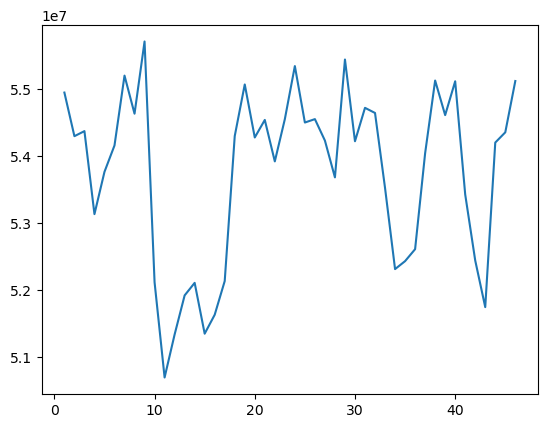

In [9]:
times = np.linspace(1, 46, 46)
print(times)
intensity = results[1600][6]
print(intensity)
plt.plot(times, intensity)
print(type(intensity))

In [12]:
def coefficient_of_variation(intensities: np.ndarray) -> float:
    """
    Computes the coefficient of variation (CV) for a given array of intensity values.

    Parameters:
    intensities (np.ndarray): Array of intensity values.

    Returns:
    float: The coefficient of variation (standard deviation / mean) as a percentage.
    """
    mean_intensity = np.mean(intensities)
    std_intensity = np.std(intensities, ddof=1)  # Use ddof=1 for sample standard deviation
    CV = std_intensity / mean_intensity if mean_intensity != 0 else np.nan  # Avoid division by zero
    return CV*100 # Convert to percentage

# Example usage:
cv = coefficient_of_variation(intensity)
print(f"Coefficient of Variation: {cv:.4f} %")

Coefficient of Variation: 2.4230 %


In [10]:
results = multi_analysis([1300], cal_results, sample_results, 'I')

# Check the results
if results:
    for wl, data in results.items():
        print(f"Wavelength: {wl}")
        print(f"{data[0]}, Mueller matrix of the sample (left).")
        print(f"{data[1]}, Mueller matrix of the sample (right).")
        print(f"Retardance of the sample (left): {data[2]}")
        print(f"Retardance of the sample (right): {data[3]}")
        print(f"Retardance error (left): {data[4]}")
        print(f"Retardance error (right): {data[5]}")
        print(f"{data[6]}, Mueller matrix of the calibration (left).")
        print(f"{data[7]}, Mueller matrix of the calibration (left).")
        print(f"RMS error of the left calibration matrix: {data[8]}")
        print(f"RMS error of the right calibration matrix: {data[9]}")
        print(f"Fit parameters (left) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[10]}")
        print(f"Fit parameters (right) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[11]}")

else:
    print("No results to display.")

Wavelength: 1300
[[ 0.98859921 -0.00197603  0.01952951  0.00468966]
 [-0.00479453  0.98843559  0.10731933  0.00785073]
 [ 0.00372778  0.07535231 -1.         -0.08378286]
 [-0.00339331 -0.00165588  0.0988923  -0.98112012]], Mueller matrix of the sample (left).
[[ 0.97792297 -0.02205926  0.00704553  0.01088215]
 [-0.00656787  1.          0.0810413  -0.00863668]
 [-0.00698139  0.09329272 -0.97090156 -0.08014688]
 [-0.00260846 -0.01261361  0.07838925 -0.9772035 ]], Mueller matrix of the sample (right).
Retardance of the sample (left): 0.5
Retardance of the sample (right): 0.47259868195835786
Retardance error (left): nan
Retardance error (right): 0.09241230385196607
[[ 0.99607395 -0.00218222 -0.00301511  0.00412569]
 [ 0.00286156  0.98704813 -0.00729976 -0.00077985]
 [ 0.00021333  0.00024577  1.          0.00290543]
 [ 0.00344101  0.00359065  0.00318108  0.99228369]], Mueller matrix of the calibration (left).
[[ 0.96134072 -0.01486025 -0.00235348 -0.00197475]
 [-0.01743485  1.          0.00

c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:438: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


In [17]:
results_x5_y5 = multi_analysis([1400], cal_results, sample_results_x5_y5, 'I')

# Check the results
if results_x5_y5:
    for wl, data in results_x5_y5.items():
        print(f"Wavelength: {wl}")
        print(f"{data[0]}, Mueller matrix of the sample (left).")
        print(f"{data[1]}, Mueller matrix of the sample (right).")
        print(f"Retardance of the sample (left): {data[2]}")
        print(f"Retardance of the sample (right): {data[3]}")
        print(f"Retardance error (left): {data[4]}")
        print(f"Retardance error (right): {data[5]}")
        print(f"{data[6]}, Mueller matrix of the calibration (left).")
        print(f"{data[7]}, Mueller matrix of the calibration (left).")
        print(f"RMS error of the left calibration matrix: {data[8]}")
        print(f"RMS error of the right calibration matrix: {data[9]}")
        print(f"Fit parameters (left) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[10]}")
        print(f"Fit parameters (right) for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer: {data[11]}")

else:
    print("No results to display.")

Wavelength: 1400
[[ 0.98933388  0.01345975  0.00146021  0.02256661]
 [-0.02022375  0.66162202 -0.76614873  0.00099256]
 [ 0.02105632 -0.81313531 -0.62175557 -0.04358616]
 [-0.01892139  0.0346331   0.02048373 -1.        ]], Mueller matrix of the sample (left).
[[ 0.99035082  0.01877758  0.0077107   0.00171354]
 [ 0.0395938   0.58614302 -0.81636609 -0.00417793]
 [-0.02864433 -0.74779913 -0.65589651 -0.0452864 ]
 [ 0.00838591  0.0009427   0.06618176 -1.        ]], Mueller matrix of the sample (right).
Retardance of the sample (left): 0.47271393187310096
Retardance of the sample (right): 0.5
Retardance error (left): 0.18277100822575526
Retardance error (right): nan
[[ 1.         -0.05917564  0.03628908 -0.00990506]
 [ 0.00959491  0.92920474  0.03677384 -0.01083013]
 [ 0.01890227 -0.02069012  0.9470899  -0.01026035]
 [-0.00315427  0.00274878  0.00301389  0.98130343]], Mueller matrix of the calibration (left).
[[ 0.95442428 -0.04327291 -0.02217842 -0.00756752]
 [-0.0121971   0.96739002  0.02

c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:438: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


middle position wavelengths with nan: 1300, 1400, 1600, 1750, 1850

In [60]:
# example usage
results = multi_analysis([1300], cal_results, sample_results, 'I')
matrix1300 = results[1300][0]
calmatrix1300 = results[1300][6]
RMS1300 = results[1300][8]
print(matrix1300)
print(calmatrix1300)
print(RMS1300)

[[ 0.98859921 -0.00197603  0.01952951  0.00468966]
 [-0.00479453  0.98843559  0.10731933  0.00785073]
 [ 0.00372778  0.07535231 -1.         -0.08378286]
 [-0.00339331 -0.00165588  0.0988923  -0.98112012]]
[[ 0.99607395 -0.00218222 -0.00301511  0.00412569]
 [ 0.00286156  0.98704813 -0.00729976 -0.00077985]
 [ 0.00021333  0.00024577  1.          0.00290543]
 [ 0.00344101  0.00359065  0.00318108  0.99228369]]
0.004867389525495311


c:\Users\EPL User\Documents\GitHub\wcmelby-HWP_Characterizations\SuperK_Select_Data\JHK_Plate\../../operational_scripts\New_DRRP_Functions.py:438: RuntimeWarning: invalid value encountered in sqrt
  return 2*RMS/np.sqrt(4*x-x**2) # Value in radians


In [61]:
# example usage
results = multi_analysis([1300], cal_results, sample_results, 'q')
matrix1300 = results[1300][0]
calmatrix1300 = results[1300][2]
RMS1300 = results[1300][3]
print(matrix1300)
print(calmatrix1300)
print(RMS1300)

[[ 1.         -0.00145189  0.00898471  0.00412712]
 [ 0.00314272  0.98341641 -0.19348402 -0.0079467 ]
 [-0.00087489 -0.19724947 -0.98864373 -0.08253129]
 [-0.00305581  0.00540021  0.0902392  -0.99674798]]
[[ 0.98003192  0.00667872 -0.00010564  0.00330991]
 [ 0.00130336  0.9919232  -0.00090953  0.00051989]
 [-0.00204474 -0.00020747  1.         -0.00251347]
 [ 0.00096795 -0.00123904  0.00167915  0.98306959]]
0.007179828775643197


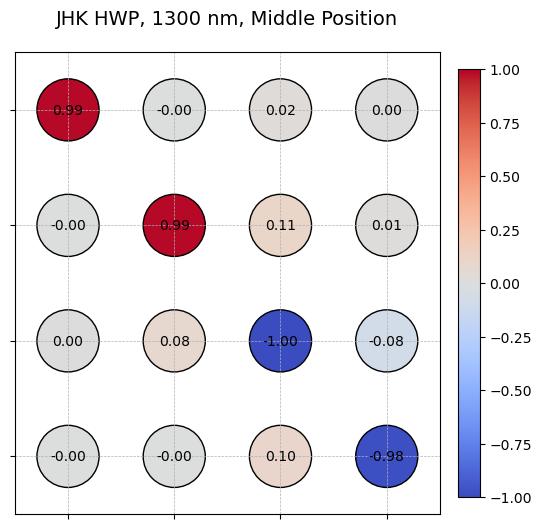

In [ ]:
M = matrix1300  # Use your existing matrix variable

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-0.5, 3.5)
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, linestyle="--", linewidth=0.5)

# Create scatter plot for the matrix elements
x, y = np.meshgrid(range(4), range(4))
sc = ax.scatter(x, y, c=M, s=2000, cmap="coolwarm", vmin=-1, vmax=1, edgecolors="black")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_label("Mueller Matrix Value")

# Annotate values
for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=10, color="black")

# Invert y-axis to match matrix order
plt.gca().invert_yaxis()

# Set title at the top
plt.title("JHK HWP, 1300 nm, Middle Position", fontsize=14, pad=20)
# plt.savefig('JHK_Matrix_1300nm.png', format='png')

# Show the plot
plt.show()

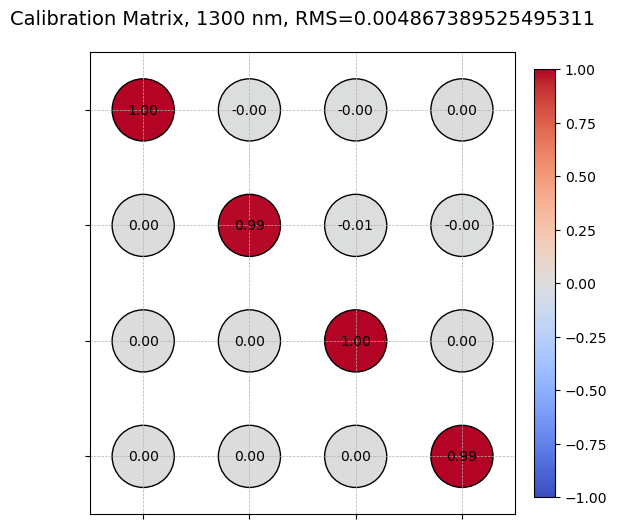

In [ ]:
M = calmatrix1300  # Use your existing matrix variable

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-0.5, 3.5)
ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, linestyle="--", linewidth=0.5)

# Create scatter plot for the matrix elements
x, y = np.meshgrid(range(4), range(4))
sc = ax.scatter(x, y, c=M, s=2000, cmap="coolwarm", vmin=-1, vmax=1, edgecolors="black")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_label("Mueller Matrix Value")

# Annotate values
for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=10, color="black")

# Invert y-axis to match matrix order
plt.gca().invert_yaxis()

# Set title at the top
plt.title(f"Calibration Matrix, 1300 nm, RMS={RMS1300}", fontsize=14, pad=20)
# plt.savefig('Calibration_Matrix_1300nm.png', format='png')

# Show the plot
plt.show()

# Analysis

In [13]:
results = multi_analysis(wavelengths, cal_results, sample_results, 'I')
I_retardance_averages = []
I_RMS_averages = []
Cal_intensities = []

for wavelength in wavelengths:
    retardance_avg_value = (results[wavelength][2] + results[wavelength][3])/2
    RMS_avg_value = (results[wavelength][8] + results[wavelength][9])/2

    I_retardance_averages.append(retardance_avg_value)
    I_RMS_averages.append(RMS_avg_value)
    Cal_intensities.append(results[wavelength][12])

print(wavelengths)
print(I_retardance_averages)

[1100, 1200, 1300, 1400, 1500, 1600, 1750, 1850, 1950]
[0.46698976355066946, 0.4818345316433039, 0.4969258997102576, 0.5, 0.49524908627742475, 0.5, 0.5, 0.5, 0.48404382846543614]


In [14]:
for intensity in Cal_intensities:
    cv = coefficient_of_variation(intensity)
    print(f"Coefficient of Variation: {cv:.4f} %")

Coefficient of Variation: 1.2226 %
Coefficient of Variation: 0.7098 %
Coefficient of Variation: 1.0381 %
Coefficient of Variation: 2.3422 %
Coefficient of Variation: 2.3127 %
Coefficient of Variation: 2.4230 %
Coefficient of Variation: 0.9291 %
Coefficient of Variation: 2.9420 %
Coefficient of Variation: 1.3209 %


In [15]:
Cal_CV = [coefficient_of_variation(intensity) for intensity in Cal_intensities]
print(Cal_CV)

[1.2226340475498085, 0.7097843275669986, 1.0380943110586545, 2.3422058110408375, 2.3127112194196298, 2.42297583092854, 0.9291149272818683, 2.9420346021723995, 1.3209307477971635]


In [16]:
results = multi_analysis(wavelengths, cal_results, sample_results, 'q')
Q_retardances = []
Q_RMS_errors = []

for wavelength in wavelengths:
    retardance_value = results[wavelength][1]
    RMS_error = results[wavelength][3]
    
    Q_retardances.append(retardance_value)
    Q_RMS_errors.append(RMS_error)

print(wavelengths)
print(Q_retardances)

[1100, 1200, 1300, 1400, 1500, 1600, 1750, 1850, 1950]
[0.46718401903781925, 0.4803980606070216, 0.5, 0.4954119535915603, 0.49314154597764465, 0.5, 0.5, 0.49187835811000863, 0.4818261129282001]


In [17]:
results_x5_y5 = multi_analysis(wavelengths, cal_results, sample_results_x5_y5, 'I')
I_retardance_averages_x5_y5 = []
I_RMS_averages_x5_y5 = []

for wavelength in wavelengths:
    retardance_avg_value = (results_x5_y5[wavelength][2] + results_x5_y5[wavelength][3])/2
    RMS_avg_value = (results_x5_y5[wavelength][8] + results_x5_y5[wavelength][9])/2

    I_retardance_averages_x5_y5.append(retardance_avg_value)
    I_RMS_averages_x5_y5.append(RMS_avg_value)

print(wavelengths)
print(I_retardance_averages_x5_y5)

[1100, 1200, 1300, 1400, 1500, 1600, 1750, 1850, 1950]
[0.4661472164453214, 0.48309056729223226, 0.4980581167365471, 0.5, 0.495604607142184, 0.49828314048456124, 0.5, 0.5, 0.5]


In [18]:
results = multi_analysis(wavelengths, cal_results, sample_results_x5_y5, 'q')
Q_retardances_x5_y5 = []
Q_RMS_errors_x5_y5 = []

for wavelength in wavelengths:
    retardance_value = results[wavelength][1]
    RMS_error = results[wavelength][3]
    
    Q_retardances_x5_y5.append(retardance_value)
    Q_RMS_errors_x5_y5.append(RMS_error)

print(wavelengths)
print(Q_retardances_x5_y5)

[1100, 1200, 1300, 1400, 1500, 1600, 1750, 1850, 1950]
[0.46770690780275903, 0.4809702820165978, 0.4943064140185003, 0.49615030369413626, 0.4896683514882425, 0.49628549353642987, 0.5, 0.4892242115725041, 0.5]


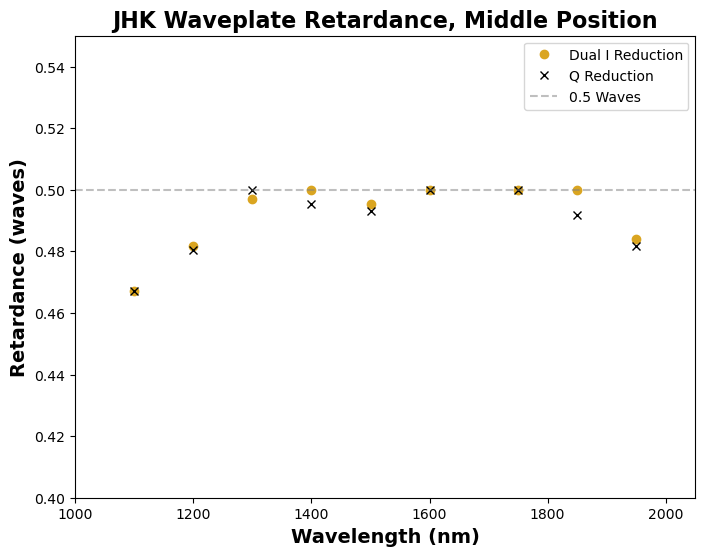

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, I_retardance_averages, 'o', color='goldenrod', label='Dual I Reduction')
# plt.plot(wavelengths, I_retardance_averages_x5_y5, '^', color='k', label='x_5 y_5 Positon, Dual I Inversion')
plt.plot(wavelengths, Q_retardances, 'x', color='k', label='Q Reduction')
# plt.plot(wavelengths, Q_retardances_x5_y5, 'x', color='k', label='x_5 y_5 Positon Positon, Q Inversion')
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='0.5 Waves')
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=14)
plt.ylabel('Retardance (waves)', fontweight='bold', fontsize=14)
plt.xlim([1000, 2050])
plt.ylim([0.4, 0.55])
plt.title('JHK Waveplate Retardance, Middle Position', fontweight='bold', fontsize=16)
plt.legend()
# plt.savefig('JHK_Retardance_I.png', format='png')
plt.show()

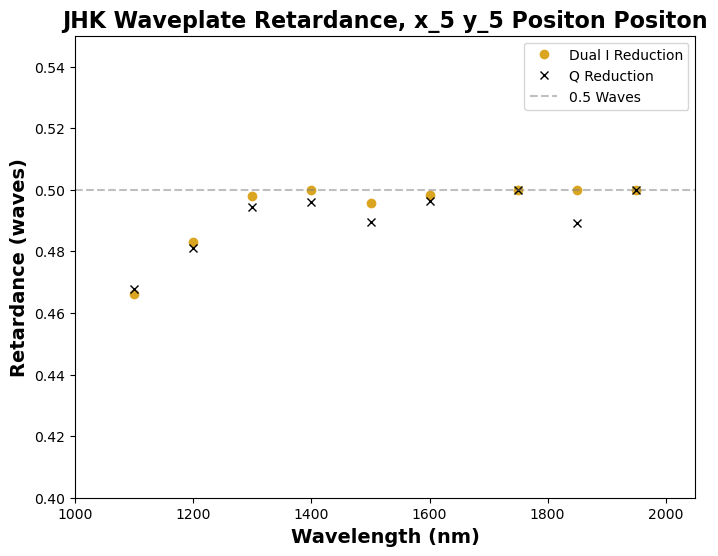

In [20]:
plt.figure(figsize=(8, 6))
# plt.plot(wavelengths, I_retardance_averages, '^', color='orangered', label='Middle Positon, Dual I Inversion')
plt.plot(wavelengths, I_retardance_averages_x5_y5, 'o', color='goldenrod', label='Dual I Reduction')
# plt.plot(wavelengths, Q_retardances, 'x', color='orangered', label='Middle Positon, Q Inversion')
plt.plot(wavelengths, Q_retardances_x5_y5, 'x', color='k', label='Q Reduction')
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='0.5 Waves')
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=14)
plt.ylabel('Retardance (waves)', fontweight='bold', fontsize=14)
plt.xlim([1000, 2050])
plt.ylim([0.4, 0.55])
plt.title('JHK Waveplate Retardance, x_5 y_5 Positon Positon', fontweight='bold', fontsize=16)
plt.legend()
# plt.savefig('JHK_Retardance_I.png', format='png')
plt.show()

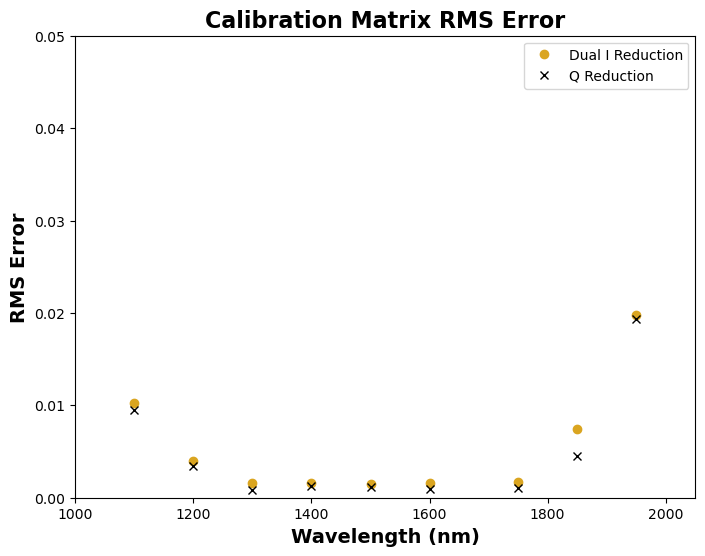

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, I_RMS_averages, 'o', color='goldenrod', label='Dual I Reduction')
plt.plot(wavelengths, Q_RMS_errors, 'x', color='k', label='Q Reduction')
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=14)
plt.ylabel('RMS Error', fontweight='bold', fontsize=14)
plt.xlim([1000, 2050])
plt.ylim([0, 0.05])
plt.title('Calibration Matrix RMS Error', fontweight='bold', fontsize=16)
plt.legend()
# plt.savefig('JHK_Retardance_I.png', format='png')
plt.show()

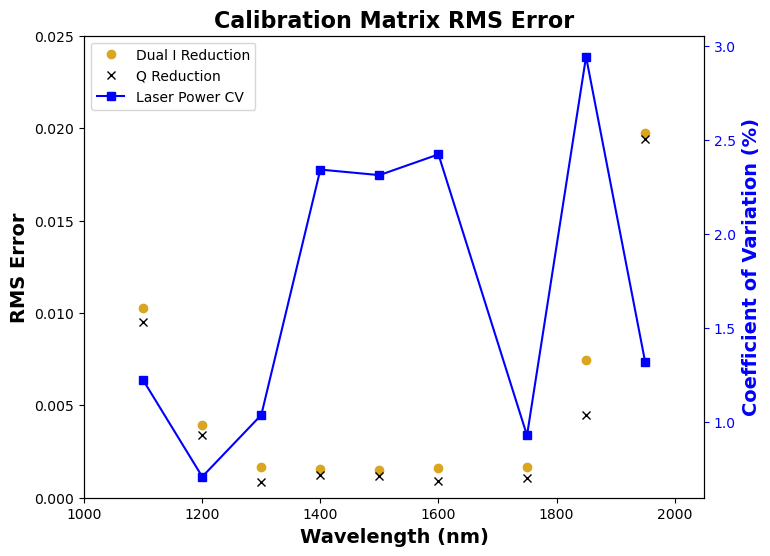

In [26]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Primary axis (Left Y-axis)
p1, = ax1.plot(wavelengths, I_RMS_averages, 'o', color='goldenrod', label='Dual I Reduction')
p2, = ax1.plot(wavelengths, Q_RMS_errors, 'x', color='k', label='Q Reduction')

ax1.set_xlabel('Wavelength (nm)', fontweight='bold', fontsize=14)
ax1.set_ylabel('RMS Error', fontweight='bold', fontsize=14)
ax1.set_xlim([1000, 2050])
ax1.set_ylim([0, 0.025])
ax1.set_title('Calibration Matrix RMS Error', fontweight='bold', fontsize=16)

# Secondary axis (Right Y-axis for CV values)
ax2 = ax1.twinx()
p3, = ax2.plot(wavelengths, Cal_CV, 's-', color='b', label='Laser Power CV')
ax2.set_ylabel('Coefficient of Variation (%)', fontweight='bold', fontsize=14, color='blue')
ax2.tick_params(axis='y', colors='blue')

# Combine all legend handles and labels into one legend on ax1
handles = [p1, p2, p3]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left')

plt.show()

In [27]:
print(I_RMS_averages)
print(Q_RMS_errors)

[0.010255525034940049, 0.0039252817750333, 0.0016356280559297125, 0.0015702766593659843, 0.0015159644885795502, 0.0016343415422606466, 0.0016831322768371178, 0.007464457832353695, 0.01972696416057587]
[0.009521105656635765, 0.003397658160913984, 0.0008487276011290883, 0.0012501562784952948, 0.0011618328979858233, 0.0009037758589933233, 0.001072866414633527, 0.004471888298972934, 0.01939005986902231]


Dodge for MgF2, Ghosh for SiO2 (quartz)

In [ ]:
n_e = np.loadtxt("/home/shared/exoserver/Lab_Data/Mueller_Matrix_Polarimeter/L_Plate_Characterization/SuperK_Select_Data/Dodge-e.csv", delimiter=",",skiprows=1)
n_o = np.loadtxt("/home/shared/exoserver/Lab_Data/Mueller_Matrix_Polarimeter/L_Plate_Characterization/SuperK_Select_Data/Dodge-o.csv", delimiter=",",skiprows=1)